NIM : 2106061
Nama : Tiara Febrianti
Kelas : B

Link Dataset yang digunakan : https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria

In [4]:
#Import Library Tensorflow
import tensorflow as tf
print(tf.__version__)

2.15.0


In [5]:
#Install Kaggle
! pip install -q kaggle

In [6]:
#Input kaggle api untuk memudahkan input dataset dari kaggle
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"tiarafebrianti160202","key":"dafb7a83b71f0a10aa2273429466d3d3"}'}

In [7]:
!chmod 600 /content/kaggle.json

In [8]:
#Input data kaggle yang akan digunakan
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 99% 671M/675M [00:06<00:00, 160MB/s]
100% 675M/675M [00:06<00:00, 102MB/s]


In [9]:
import os, zipfile
local_zip = '/content/cell-images-for-detecting-malaria.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content') #unzip atau mengekstrak file zip dataset
zip_ref.close()


In [10]:
#Data yang akan digunakan
base_dir = '/content/cell_images'

In [11]:
#Preprocessing Data
import numpy as np
import pandas as pd

def data_prep(parasitized,uninfected):

    parasitized= ["/content/cell_images/Parasitized" + '/' +  parasitize for parasitize in parasitized] #Membaca data dari folder
    uninfected= ["/content/cell_images/Uninfected" + '/' +  uninfect for uninfect in uninfected] #Membaca data dari folder

    labels = len(parasitized)*['Terinfeksi'] + len(uninfected)*['Tidak Terinfeksi'] #Labeling
    data = parasitized + uninfected

    return pd.DataFrame({'Image_Path': data , 'Labels': labels})


df = data_prep(os.listdir('/content/cell_images/Parasitized/'), os.listdir('/content/cell_images/Uninfected/'))
df.head()

,Image_Path,Labels
0,/content/cell_images/Parasitized/C128P89ThinF_...,Terinfeksi
1,/content/cell_images/Parasitized/C128P89ThinF_...,Terinfeksi
2,/content/cell_images/Parasitized/C68P29N_ThinF...,Terinfeksi
3,/content/cell_images/Parasitized/C133P94ThinF_...,Terinfeksi
4,/content/cell_images/Parasitized/C68P29N_ThinF...,Terinfeksi


Menampilkan 5 Gambar yang Terinfeksi: 



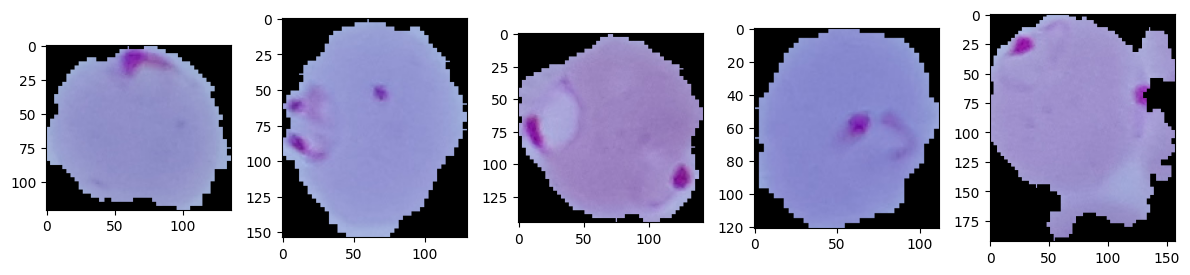


Menampilkan 5 Gambar yang Tidak Terinfeksi: 



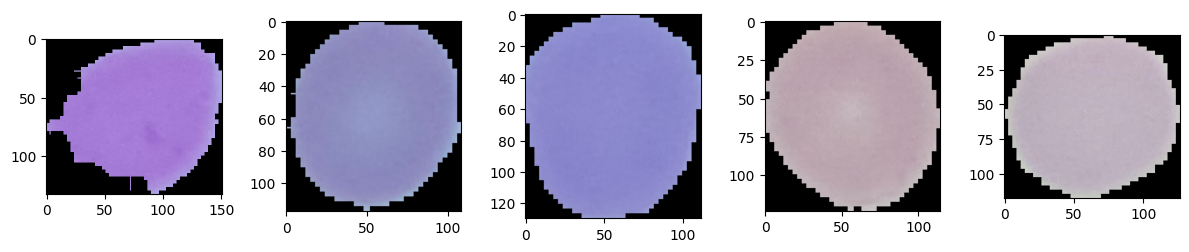

In [12]:
#Library import untuk gambar dari kedua kelas yang telah dilabeling
import matplotlib.pyplot as plt
import cv2

print("Menampilkan 5 Gambar yang Terinfeksi: ")
print()
plt.figure(figsize = (12,12))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = cv2.imread(df[df['Labels'] == 'Terinfeksi']['Image_Path'][i])
    plt.imshow(img)
    plt.tight_layout()
plt.show()


print()
print("Menampilkan 5 Gambar yang Tidak Terinfeksi: ")
print()
plt.figure(figsize = (12,12))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = cv2.imread(df[df['Labels'] == 'Tidak Terinfeksi']['Image_Path'].reset_index(drop=True)[i])
    plt.imshow(img)
    plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Distribution of samples according to the categories')

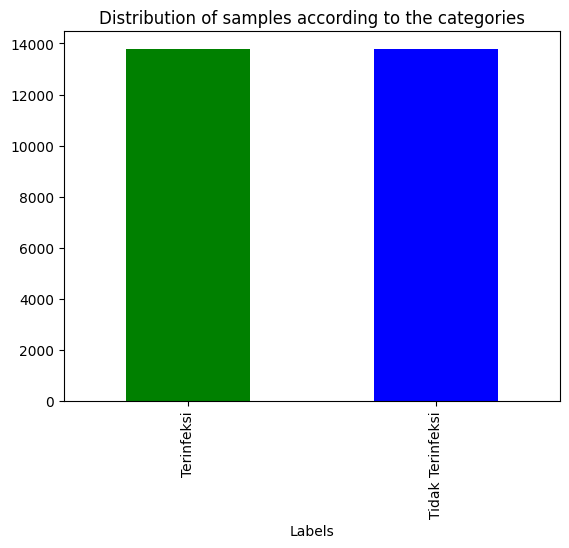

In [13]:
#Visualisasi Bar Chart untuk distribusi data Label
df['Labels'].value_counts().plot(kind = 'bar', color = ['green', 'blue'])
plt.title('Distribution of samples according to the categories')

In [14]:
#Augmentasi Data
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train, test = train_test_split(df, test_size = .20)

img_datagen = ImageDataGenerator(rotation_range=20,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest', validation_split=0.2) #Splitting Dataset dimana testing = 0.2, sehingga training = 0.8

class stop(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('accuracy') > 0.92) and (logs.get('val_accuracy') > 0.92)):
      print('\nAkurasi sudah melampaui 92%')
      self.model.stop_training = True

my_callbacks = [
    EarlyStopping(patience=2),
    stop()
]

In [15]:
#Jumlah Data Training dari splitting dataset sebesar 0.8
train.shape

(22048, 2)

In [16]:
#Jumlah Data Testing dari splitting dataset sebesar 0.2
test.shape

(5512, 2)

In [17]:
#Data Generator Training dan Testint
import warnings
warnings.filterwarnings('ignore')

x_train =  img_datagen.flow_from_dataframe(
    dataframe = train,
    x_col='Image_Path',
    y_col='Labels',
    class_mode='binary',
    target_size=(224,224),
    shuffle=False,
    batch_size=10,
    seed=10,
    subset='training')

x_val = img_datagen.flow_from_dataframe(
    dataframe = train,
    x_col='Image_Path',
    y_col='Labels',
    class_mode='binary',
    target_size=(224,224),
    shuffle=False,
    batch_size=10,
    seed=10,
    subset='validation')

Found 17637 validated image filenames belonging to 2 classes.
Found 4409 validated image filenames belonging to 2 classes.


In [42]:
from keras import models
from keras import layers
from keras.applications import resnet50
from keras.models import *
from keras.layers import *
import keras

#Function untuk model CNN berdasarkan kernel dengan aktivasi relu
def my_model(df, x_train, x_val, my_callbacks):
    model = tf.keras.Sequential(
        [
          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(224,224,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(224,224,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(224,224,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(224,224,3) ,filters=64, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(1024, activation='relu'),
          tf.keras.layers.Dropout(rate=0.5),
          tf.keras.layers.Dense(1, activation='sigmoid') #Aktivasi sigmoid untuk layer dropout
  ])

    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

    model_history = model.fit(x_train,
                            validation_data=x_val,
                            epochs = 4, callbacks=my_callbacks) #4 epoch yang akan berhenti otomatis saat akurasi telah cukup baik

    return model_history, model

history_model,models = my_model(df, x_train, x_val, my_callbacks)

Epoch 1/4
1764/1764 [==============================] - 1837s 1s/step - loss: 0.7450 - accuracy: 0.8016 - val_loss: 0.2710 - val_accuracy: 0.9231
Epoch 2/4
1764/1764 [==============================] - ETA: 0s - loss: 0.2171 - accuracy: 0.9339
Akurasi sudah melampaui 92%
1764/1764 [==============================] - 1812s 1s/step - loss: 0.2171 - accuracy: 0.9339 - val_loss: 0.2062 - val_accuracy: 0.9408


Dihasilkan akurasi melebihi 92% = 0.9339

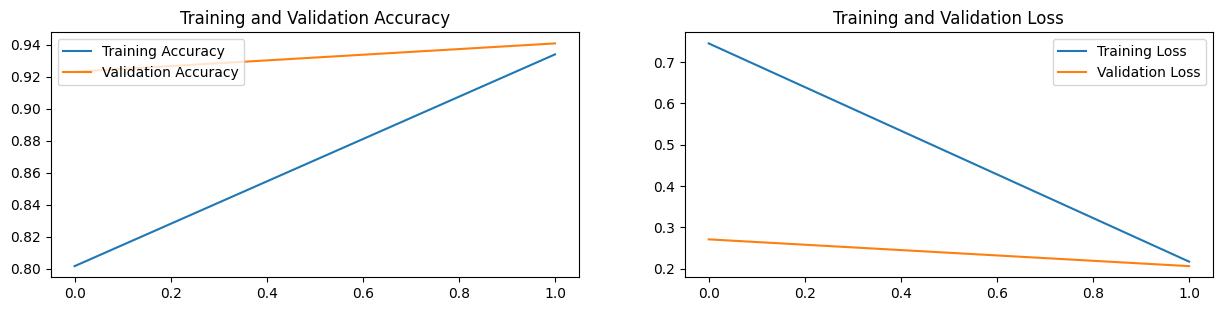

In [43]:
#Visualisasi Plot Akurasi dan Loss
accuracy = history_model.history['accuracy']
loss = history_model.history['loss']
validation_loss = history_model.history['val_loss']
validation_accuracy = history_model.history['val_accuracy']

plt.figure(figsize=(15, 7))
plt.subplot(2, 2, 1)
plt.plot(range(len(accuracy)), accuracy, label='Training Accuracy')
plt.plot(range(len(accuracy)), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(range(len(accuracy)), loss, label='Training Loss')
plt.plot(range(len(accuracy)), validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.show()

Saving cobaterinfeksi1.png to cobaterinfeksi1 (2).png
1/1 [==============================] - 0s 313ms/step
Predictions: Terinfeksi


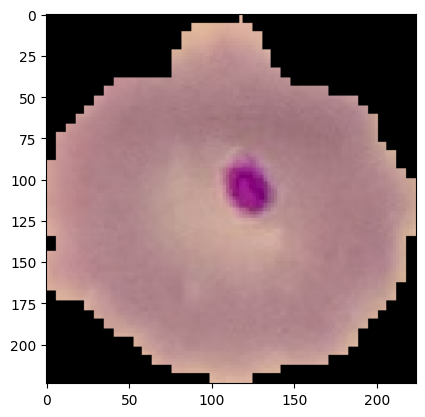

In [44]:
# Berfungsi untuk melakukan prapemrosesan gambar input
def preprocess_image(img):
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Perluas dimensi agar sesuai dengan ukuran batch

    return img

def predict_single_image(image_path):
    processed_img = preprocess_image(image_path)
    prediction = models.predict(processed_img)
    if prediction < 0.5:
        return "Terinfeksi"
    else:
        return "Tidak Terinfeksi"

# Unggah file gambar
uploaded = files.upload()

# Dapatkan file gambar yang diunggah
for fn in uploaded.keys():
    image_path = fn

# Memuat gambar yang diunggah
img = image.load_img(image_path, target_size=(224, 224))
imgplot = plt.imshow(img)
# Membuat prediksi
predictions = predict_single_image(img)
print("Predictions:", predictions)

Saving cobatidakterinfeksi.png to cobatidakterinfeksi.png
1/1 [==============================] - 0s 43ms/step
Predictions: Tidak Terinfeksi


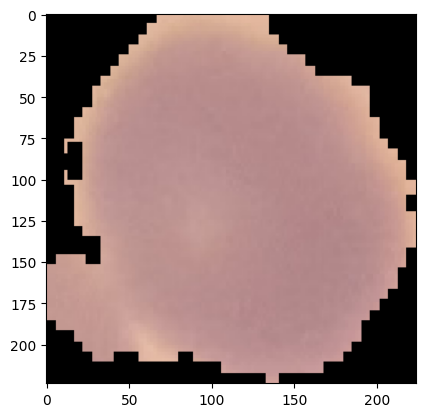

In [45]:
# Berfungsi untuk melakukan prapemrosesan gambar input
def preprocess_image(img):
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Perluas dimensi agar sesuai dengan ukuran batch

    return img

def predict_single_image(image_path):
    processed_img = preprocess_image(image_path)
    prediction = models.predict(processed_img)
    if prediction < 0.5:
        return "Terinfeksi"
    else:
        return "Tidak Terinfeksi"

# Unggah file gambar
uploaded = files.upload()

# Dapatkan file gambar yang diunggah
for fn in uploaded.keys():
    image_path = fn

# Memuat gambar yang diunggah
img = image.load_img(image_path, target_size=(224, 224))
imgplot = plt.imshow(img)
# Membuat prediksi
predictions = predict_single_image(img)
print("Predictions:", predictions)

Model berhasil memprediksi gambar dengan baik, dapat dilakukan konversi model untuk menyimpan model

In [37]:
# Konversi Model ke tf.lite
converter = tf.lite.TFLiteConverter.from_keras_model(models)
tflite_model = converter.convert()

# Simpan model yang telah dikonversi
with tf.io.gfile.GFile('model-proyek-uts.tflite', 'wb') as f:
  f.write(tflite_model)


In [38]:
from google.colab import files

# Mendownload file model untuk bisa diimplementasikan pada
files.download('/content/model-proyek-uts.tflite')

print('`model-proyek-uts.tflite` sudah berhasil didownload')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

`model-proyek-uts.tflite` sudah berhasil didownload
